In [2]:
import os

# Print the current working directory
print("Current Working Directory:", os.getcwd())

Current Working Directory: /content


In [ ]:
pip install torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 45.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 57.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 56.1 MB/s eta 0:00:00


In [3]:
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

In [4]:
# Load the data
data = pd.read_csv("data.csv")
data.head()

,date,id,sku_id,price,sku_name,gender,category,brand,collection,price_tier,style,cost,sales
0,24-05-2020,400,0,1.9,jeans_female_brand_2_P_middle_sport,female,jeans,brand_2,P,middle,sport,43.63,577.0
1,24-05-2020,800,0,1.9,jeans_female_brand_2_P_middle_sport,female,jeans,brand_2,P,middle,sport,43.63,545.0
2,24-05-2020,1200,0,1.9,jeans_female_brand_2_P_middle_sport,female,jeans,brand_2,P,middle,sport,43.63,565.0
3,24-05-2020,1600,0,1.9,jeans_female_brand_2_P_middle_sport,female,jeans,brand_2,P,middle,sport,43.63,536.0
4,24-05-2020,2000,0,1.9,jeans_female_brand_2_P_middle_sport,female,jeans,brand_2,P,middle,sport,43.63,568.0


In [5]:

# Handle missing values
data['sales'].fillna(data['sales'].mean(), inplace=True)

# Convert the 'date' column to datetime
data['date'] = pd.to_datetime(data['date'])

# Encode categorical variables
categorical_features = ['gender', 'category', 'brand', 'collection', 'price_tier', 'style']
encoder = OneHotEncoder()
encoded_categorical = encoder.fit_transform(data[categorical_features])

# Concatenate encoded categorical features with the rest of the data
encoded_features = pd.DataFrame(encoded_categorical.toarray(), columns=encoder.get_feature_names_out(categorical_features))
data = pd.concat([data.drop(categorical_features, axis=1), encoded_features], axis=1)


<ipython-input-5-f4430d45863c>:5: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  data['date'] = pd.to_datetime(data['date'])


In [6]:
# Extract day, month, and year from the date
data['day'] = data['date'].dt.day
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year

# Calculate profit
data['profit'] = (data['price'] - data['cost']) * data['sales']


In [7]:
print(data.columns)


Index(['date', 'id', 'sku_id', 'price', 'sku_name', 'cost', 'sales',
       'gender_female', 'gender_male', 'category_boots', 'category_jacket',
       'category_jeans', 'category_shoes', 'category_t-shirt', 'category_top',
       'category_trainers', 'brand_brand_1', 'brand_brand_2', 'brand_brand_3',
       'brand_brand_4', 'collection_AW', 'collection_P', 'collection_SS',
       'price_tier_high', 'price_tier_low', 'price_tier_middle',
       'style_casual', 'style_sport', 'day', 'month', 'year', 'profit'],
      dtype='object')


In [8]:
features = [col for col in data.columns if col not in ('date', 'id','sku_name')]

# Now, let's set up our features (X) and target (y)
X = data[features].values
y = data['sales'].values.reshape(-1, 1) # Assuming you want to predict 'sales'

# Normalize the features and the target
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)


In [9]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


In [16]:
# DataLoader for batch processing
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)


In [12]:
# Define the neural network model
class SalesNet(nn.Module):
    def __init__(self, input_size):
        super(SalesNet, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.network(x)


In [13]:
# Instantiate the model
model = SalesNet(X_train.shape[1])

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        # Forward pass
        predictions = model(inputs)
        loss = criterion(predictions, targets)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch+1) % 1 == 0:  # Print every 1 epoch
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

Epoch 1/10, Loss: 0.0003827085602097213
Epoch 2/10, Loss: 0.0004047580005135387
Epoch 3/10, Loss: 5.448744923342019e-05
Epoch 4/10, Loss: 0.000334311684127897
Epoch 5/10, Loss: 4.337240898166783e-05
Epoch 6/10, Loss: 9.468630742048845e-05
Epoch 7/10, Loss: 4.037047256133519e-05
Epoch 8/10, Loss: 0.0002453054185025394
Epoch 9/10, Loss: 5.505839362740517e-05
Epoch 10/10, Loss: 4.168419764027931e-05


In [18]:
# After training the model

# Set the model to evaluation mode
model.eval()

# Perform inference on the test data
with torch.no_grad():
    predictions = model(X_test_tensor)

# Convert predictions back to original scale
predictions = scaler_y.inverse_transform(predictions)

# Get actual costs from the test data
# Assuming 'cost' column is available in the original data
costs = X_test[:, features.index('cost')]  # Adjust this based on your data

# Calculate profit using predictions and actual costs
profits = predictions - costs

# Find the index of the price that maximizes profit
optimal_price_index = profits.argmax()
optimal_price = X_test[optimal_price_index, features.index('price')]  # Assuming 'price' column is available in the original data

# Display profit and optimal price
print(f"Profit: {profits[optimal_price_index]}")
print(f"Optimal Price: {optimal_price}")


TypeError: SalesNet.forward() missing 2 required positional arguments: 'price' and 'cost'

In [31]:
print(data.dtypes)

date                 datetime64[ns]
id                            int64
sku_id                        int64
price                       float64
sku_name                     object
cost                        float64
sales                       float64
gender_female               float64
gender_male                 float64
gender_nan                  float64
category_boots              float64
category_jacket             float64
category_jeans              float64
category_shoes              float64
category_t-shirt            float64
category_top                float64
category_trainers           float64
category_nan                float64
brand_brand_1               float64
brand_brand_2               float64
brand_brand_3               float64
brand_brand_4               float64
brand_nan                   float64
collection_AW               float64
collection_P                float64
collection_SS               float64
collection_nan              float64
price_tier_high             

In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Assuming you have loaded your data into a pandas DataFrame called 'data'
# Drop unnecessary columns (e.g., 'date', 'id', 'sku_id', 'sku_name') and target variable
X = data[['sku_id', 'price', 'cost']]
y = data['sales']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.1)

# Evaluate the model
loss = model.evaluate(X_test_scaled, y_test)
print(f'Test Loss: {loss}')

# Make predictions
predictions = model.predict(X_test_scaled)


Epoch 1/10
5670/5670 [==============================] - 17s 3ms/step - loss: 163479.7500 - val_loss: 141064.7969
Epoch 2/10
5670/5670 [==============================] - 15s 3ms/step - loss: 139264.8281 - val_loss: 140458.1875
Epoch 3/10
5670/5670 [==============================] - 14s 2ms/step - loss: 139079.5000 - val_loss: 140421.3594
Epoch 4/10
5670/5670 [==============================] - 14s 2ms/step - loss: 138951.0938 - val_loss: 140319.5625
Epoch 5/10
5670/5670 [==============================] - 14s 2ms/step - loss: 138907.5781 - val_loss: 140193.3906
Epoch 6/10
5670/5670 [==============================] - 14s 2ms/step - loss: 138873.0625 - val_loss: 140435.7656
Epoch 7/10
5670/5670 [==============================] - 14s 3ms/step - loss: 138853.4375 - val_loss: 140571.4844
Epoch 8/10
5670/5670 [==============================] - 14s 2ms/step - loss: 138837.0781 - val_loss: 140275.1562
Epoch 9/10
5670/5670 [==============================] - 14s 2ms/step - loss: 138812.4219 - val_l

In [21]:
# Define a function to calculate profit
def calculate_profit(price, predicted_sales, cost):
    cost = cost / 100
    revenue = price * predicted_sales
    total_cost = cost * predicted_sales
    profit = revenue - total_cost
    return profit.sum()

profits = []

# Define a function to find the optimal price
def find_optimal_price(model, X_test_scaled, prices, cost):
    for price in prices:
        # Create input array with constant price
        input_array = np.column_stack((X_test_scaled[:, 0], np.full(X_test_scaled.shape[0], price), X_test_scaled[:, 2]))

        # Predict sales
        predicted_sales = model.predict(input_array)

        # Calculate profit for each prediction
        profit = calculate_profit(price, predicted_sales, cost)
        profits.append(profit)

    # Find the price that maximizes profit
    optimal_price_index = np.argmax(profits)
    optimal_price = prices[optimal_price_index]
    return optimal_price

# Define the range of prices to consider
prices_to_try = np.arange(1.2, 2.6, 0.1)  # Example: prices from 1 to 100

# Assume 'cost' is the cost of the product
cost = X_test['cost'].values  # Assuming all test samples have the same cost

# Find the optimal price
optimal_price = find_optimal_price(model, X_test_scaled, prices_to_try, cost)
print("Optimal Price for Maximum Profit:", optimal_price)

# Create input array for the optimal price
optimal_input_array = np.column_stack((X_test_scaled[:, 0], np.full(X_test_scaled.shape[0], optimal_price), X_test_scaled[:, 2]))

# Predict sales for the optimal price
optimal_predicted_sales = model.predict(optimal_input_array)

# Print the sales for the optimal price
print("Sales for Optimal Price:", optimal_predicted_sales)

# Find the index of the optimal price in the original prices array
optimal_price_index = np.where(prices_to_try == optimal_price)[0][0]

# Get the corresponding sku_id for the optimal price
optimal_sku_id = X_test['sku_id'].iloc[optimal_price_index]
print("SKU ID for Optimal Price:", optimal_sku_id)

optimal_cost = X_test['cost'].iloc[optimal_price_index]

# Calculate profit for the optimal price
optimal_profit = calculate_profit(optimal_price, optimal_predicted_sales, optimal_cost)
print("Profit for Optimal Price:", optimal_profit)

1575/1575 [==============================] - 2s 1ms/step
Optimal Price for Maximum Profit: 2.500000000000001
1575/1575 [==============================] - 2s 1ms/step
Sales for Optimal Price: [[545.73016]
 [553.77435]
 [514.801  ]
 ...
 [550.2782 ]
 [540.47986]
 [546.815  ]]
SKU ID for Optimal Price: 125
Profit for Optimal Price: 52908250.0


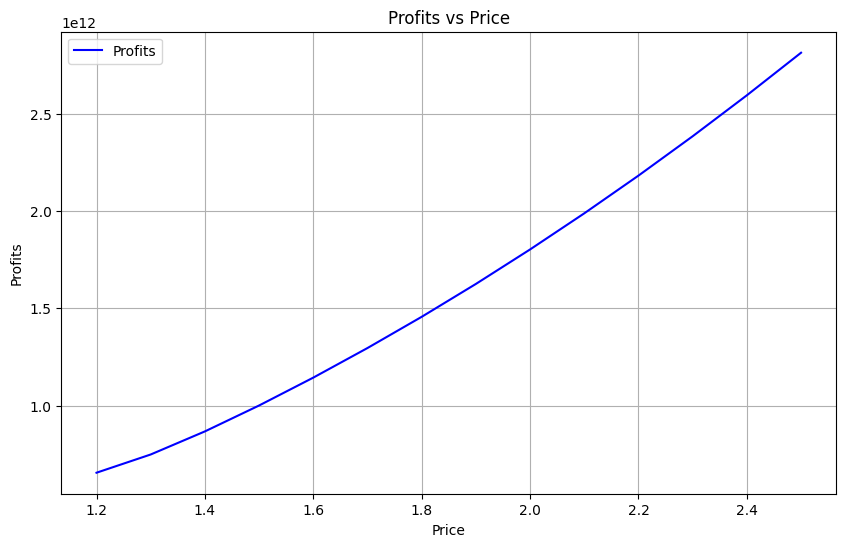

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(prices_to_try, profits, label='Profits', color='blue')
plt.xlabel('Price')
plt.ylabel('Profits')
plt.title('Profits vs Price')
plt.legend()
plt.grid(True)
plt.show()

In [53]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, f1_score, r2_score

# Make predictions
predicted_sales = model.predict(X_test_scaled)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, predicted_sales)
print("Mean Squared Error (MSE):", mse)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predicted_sales)
print("Mean Absolute Error (MAE):", mae)

# As F1 score is for classification tasks, we need to convert regression problem into classification.
# One way to do this is to binarize the predicted sales into two classes (e.g., 0 and 1) using a threshold.
# Let's use median value of the sales as threshold.
threshold = np.median(y_test)
predicted_classes = (predicted_sales > threshold).astype(int)
true_classes = (y_test > threshold).astype(int)

# Calculate F1 Score
f1 = f1_score(true_classes, predicted_classes)
print("F1 Score:", f1)

# Train the model
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Calculate R^2
r2 = r2_score(y_test, y_pred)
print("R^2 Score:", r2)

1575/1575 [==============================] - 2s 1ms/step
Mean Squared Error (MSE): 139200.7954387386
Mean Absolute Error (MAE): 280.2739983197506
F1 Score: 0.5982629427792916
1575/1575 [==============================] - 2s 1ms/step
R^2 Score: 0.30721539160253875


In [25]:
prices_to_try = np.arange(1.2, 2.6, 0.1)  # Example: prices from 1 to 100

# Assume 'cost' is the cost of the product
cost = X_test['cost'].values  # Assuming all test samples have the same cost

# Find the optimal price
optimal_price = find_optimal_price(model, X_test_scaled, prices_to_try, cost)
# Print prices and corresponding profits
for price, profit in zip(prices_to_try, profits):
    print(f"Price: {price}, Profit: {profit}")


1575/1575 [==============================] - 2s 1ms/step
Price: 1.2, Profit: 654680331948.8381
Price: 1.3, Profit: 748426053349.3271
Price: 1.4000000000000001, Profit: 867087736435.1404
Price: 1.5000000000000002, Profit: 1000316269827.7781
Price: 1.6000000000000003, Profit: 1143636994713.6082
Price: 1.7000000000000004, Profit: 1295741599351.2065
Price: 1.8000000000000005, Profit: 1456236732185.3735
Price: 1.9000000000000006, Profit: 1625231083825.2444
Price: 2.000000000000001, Profit: 1802586931951.44
Price: 2.1000000000000005, Profit: 1988252892388.692
Price: 2.200000000000001, Profit: 2182231539080.6572
Price: 2.3000000000000007, Profit: 2384529581789.237
Price: 2.4000000000000012, Profit: 2595123135355.388
Price: 2.500000000000001, Profit: 2814029629263.994


In [26]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

# Prepare the data
X = data[['sku_id', 'price', 'cost']]
y = data['sales']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define and train the Feedforward Neural Network model
model = MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', max_iter=1000, random_state=42)
model.fit(X_train_scaled, y_train)

# Predict sales for different price points
prices = data['price'].values  # Example price points
profits = []

# Define a function to calculate profit
def calculate_profit(price, predicted_sales, cost):
    cost = cost / 100
    revenue = price * predicted_sales
    total_cost = cost * predicted_sales
    profit = revenue - total_cost
    return profit.sum()

profits = []

# Define a function to find the optimal price
def find_optimal_price(model, X_test_scaled, prices, cost):
    for price in prices:
        # Create input array with constant price
        input_array = np.column_stack((X_test_scaled[:, 0], np.full(X_test_scaled.shape[0], price), X_test_scaled[:, 2]))

        # Predict sales
        predicted_sales = model.predict(input_array)

        # Calculate profit for each prediction
        profit = calculate_profit(price, predicted_sales, cost)
        profits.append(profit)

    # Find the price that maximizes profit
    optimal_price_index = np.argmax(profits)
    optimal_price = prices[optimal_price_index]
    return optimal_price

# Define the range of prices to consider
prices_to_try = np.arange(1.2, 2.6, 0.1)  # Example: prices from 1 to 100

# Assume 'cost' is the cost of the product
cost = X_test['cost'].values  # Assuming all test samples have the same cost

# Find the optimal price
optimal_price = find_optimal_price(model, X_test_scaled, prices_to_try, cost)
print("Optimal Price for Maximum Profit:", optimal_price)

# Create input array for the optimal price
optimal_input_array = np.column_stack((X_test_scaled[:, 0], np.full(X_test_scaled.shape[0], optimal_price), X_test_scaled[:, 2]))

# Predict sales for the optimal price
optimal_predicted_sales = model.predict(optimal_input_array)

# Print the sales for the optimal price
print("Sales for Optimal Price:", optimal_predicted_sales)

# Find the index of the optimal price in the original prices array
optimal_price_index = np.where(prices_to_try == optimal_price)[0][0]

# Get the corresponding sku_id for the optimal price
optimal_sku_id = X_test['sku_id'].iloc[optimal_price_index]
print("SKU ID for Optimal Price:", optimal_sku_id)

optimal_cost = X_test['cost'].iloc[optimal_price_index]

# Calculate profit for the optimal price
optimal_profit = calculate_profit(optimal_price, optimal_predicted_sales, optimal_cost)
print("Profit for Optimal Price:", optimal_profit)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Optimal Price for Maximum Profit: 2.500000000000001
Sales for Optimal Price: [ 995.4865595   801.13123348 1059.64113139 ...  984.51192756  997.56562346
  784.38953716]
SKU ID for Optimal Price: 125
Profit for Optimal Price: 88385165.83967748


In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, f1_score, r2_score

# Make predictions
predicted_sales = model.predict(X_test_scaled)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, predicted_sales)
print("Mean Squared Error (MSE):", mse)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predicted_sales)
print("Mean Absolute Error (MAE):", mae)

# As F1 score is for classification tasks, we need to convert regression problem into classification.
# One way to do this is to binarize the predicted sales into two classes (e.g., 0 and 1) using a threshold.
# Let's use median value of the sales as threshold.
threshold = np.median(y_test)
predicted_classes = (predicted_sales > threshold).astype(int)
true_classes = (y_test > threshold).astype(int)

# Calculate F1 Score
f1 = f1_score(true_classes, predicted_classes)
print("F1 Score:", f1)

# Train the model
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Calculate R^2
r2 = r2_score(y_test, y_pred)
print("R^2 Score:", r2)

Mean Squared Error (MSE): 136444.20109659826
Mean Absolute Error (MAE): 273.8411376343261
F1 Score: 0.5988926308579257
R^2 Score: 0.31566944235686367


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Assuming you have loaded your data into a pandas DataFrame called 'data'
# Drop unnecessary columns (e.g., 'date', 'id', 'sku_id', 'sku_name') and target variable
X = data[['sku_id', 'price', 'cost']]
y = data['sales']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape input data for LSTM (samples, time steps, features)
X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

# Define the LSTM model
model3 = Sequential([
    LSTM(64, activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]), return_sequences=True),
    LSTM(32, activation='relu', return_sequences=False),
    Dense(1)  # Output layer for regression
])

# Compile the model
model3.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model3.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, validation_split=0.1)

# Evaluate the model
loss = model3.evaluate(X_test_reshaped, y_test)
print(f'Test Loss: {loss}')

# Make predictions
predictions = model3.predict(X_test_reshaped)


Epoch 1/10
5670/5670 [==============================] - 29s 5ms/step - loss: 167413.0000 - val_loss: 140825.7969
Epoch 2/10
5670/5670 [==============================] - 26s 5ms/step - loss: 139183.9062 - val_loss: 140665.4062
Epoch 3/10
5670/5670 [==============================] - 26s 5ms/step - loss: 138986.9375 - val_loss: 140426.8281
Epoch 4/10
5670/5670 [==============================] - 26s 5ms/step - loss: 138449.7969 - val_loss: 139892.4844
Epoch 5/10
5670/5670 [==============================] - 26s 5ms/step - loss: 138162.9219 - val_loss: 139799.8281
Epoch 6/10
5670/5670 [==============================] - 26s 5ms/step - loss: 137920.7344 - val_loss: 139875.6250
Epoch 7/10
5670/5670 [==============================] - 26s 5ms/step - loss: 137748.9219 - val_loss: 139579.2969
Epoch 8/10
5670/5670 [==============================] - 26s 5ms/step - loss: 137514.2188 - val_loss: 139476.8906
Epoch 9/10
5670/5670 [==============================] - 26s 5ms/step - loss: 137282.6094 - val_l

In [36]:

# Define a function to calculate profit
def calculate_profit(price, predicted_sales, cost):
    cost = cost / 100
    revenue = price * predicted_sales
    total_cost = cost * predicted_sales
    profit = revenue - total_cost
    return profit.sum()

profits = []

# Define a function to find the optimal price
def find_optimal_price(model3, X_test_scaled, prices, cost):
    for price in prices:
        # Create input array with constant price
        input_array = np.column_stack((X_test_scaled[:, 0], np.full(X_test_scaled.shape[0], price), X_test_scaled[:, 2]))

        # Predict sales
        predicted_sales = model3.predict(input_array)

        # Calculate profit for each prediction
        profit = calculate_profit(price, predicted_sales, cost)
        profits.append(profit)

    # Find the price that maximizes profit
    optimal_price_index = np.argmax(profits)
    optimal_price = prices[optimal_price_index]
    return optimal_price

# Define the range of prices to consider
prices_to_try = np.arange(1.2, 2.6, 0.1)  # Example: prices from 1 to 100

# Assume 'cost' is the cost of the product
cost = X_test['cost'].values  # Assuming all test samples have the same cost

# Find the optimal price

print("Optimal Price for Maximum Profit:", optimal_price)

# Create input array for the optimal price
# Reshape X_test_scaled to add a time step dimension
X_test_lstm = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])
# Predict sales for the optimal price
optimal_predicted_sales = model3.predict(X_test_lstm)

# Print the sales for the optimal price
print("Sales for Optimal Price:", optimal_predicted_sales)

# Find the index of the optimal price in the original prices array
optimal_price_index = np.where(prices_to_try == optimal_price)[0][0]

# Get the corresponding sku_id for the optimal price
optimal_sku_id = X_test['sku_id'].iloc[optimal_price_index]
print("SKU ID for Optimal Price:", optimal_sku_id)

optimal_cost = X_test['cost'].iloc[optimal_price_index]

# Calculate profit for the optimal price
optimal_profit = calculate_profit(optimal_price, optimal_predicted_sales, optimal_cost)
print("Profit for Optimal Price:", optimal_profit)

Optimal Price for Maximum Profit: 2.500000000000001
1575/1575 [==============================] - 3s 2ms/step
Sales for Optimal Price: [[1082.2589 ]
 [1114.6265 ]
 [ 475.36356]
 ...
 [ 602.04205]
 [ 785.9157 ]
 [ 314.49716]]
SKU ID for Optimal Price: 125
Profit for Optimal Price: 63209596.0


In [43]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, f1_score, r2_score


# Calculate Mean Squared Error (MSE)
predicted_sales = model3.predict(X_test_reshaped)

y_pred = model3.predict(X_test_reshaped)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)
# Calculate R^2 score
r2 = r2_score(y_test, y_pred)
print("R^2 Score:", r2)

1575/1575 [==============================] - 3s 2ms/step
Mean Squared Error (MSE): 137643.67454800458
Mean Absolute Error (MAE): 277.68719329537134
R^2 Score: 0.3148632415061079
